In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import os 

# key: age group for scenario, 
# value: dictionary with corresponding groups in the EUROSTAT dataset 
age_groups = {'0-2mo': {"groups": ['Less than 1 year']},
              '3-5mo': {"groups": ['Less than 1 year']},
              '6-11mo': {"groups": ['Less than 1 year']},
              '1-4y': {"groups": ['1 year', '2 years', '3 years', '4 years']},
              '5-64y': {"groups": [f"{i} years" for i in np.arange(5, 65)]},
              '65+y': {"groups": [f"{i} years" for i in np.arange(65, 100)] + ['Open-ended age class']}}

months_check = {"0-2mo": 3, "3-5mo": 3, "6-11mo": 6}


def get_births_country_year(df, country, start_date, end_date):
    """
    Get the births data for a given country between start_date and end_date.
    """
    df_country = df.loc[(df["geo"] == country) & (df.date >= start_date) & (df.date <= end_date)]

    if len(df_country) == 0:
        print(f"No data found for {country} between {start_date} and {end_date}")
        return pd.DataFrame()

    df_country.rename(columns={"TIME_PERIOD": "year", 
                               "OBS_VALUE": "births", 
                               "geo": "country"}, inplace=True)

    return df_country[["country", "date", "month", "year", "births"]].reset_index(drop=True)


def compute_population_1yr_share(country, births, scenario_start_date): 
    """
    Compute the share of population in each <1yr sub-group for a given country and scenario start date
    """

    population_1yr = {"0-2mo": 0, "3-5mo": 0, "6-11mo": 0}
    population_1yr_share = {"0-2mo": 0, "3-5mo": 0, "6-11mo": 0}
    scenario_start_date = pd.to_datetime(scenario_start_date)

    for grp in population_1yr: 
        # get start and end extremes of the age group
        start, end = int(grp.split("-")[0]), int(grp.split("-")[1].replace("mo", ""))

        # get start and end dates for births
        start_date = scenario_start_date - pd.DateOffset(months=end+1)
        end_date = scenario_start_date - pd.DateOffset(months=start)

        # get births that contribute to the population in the given age group
        births_grp = births[(births.date >= start_date) & (births.date < end_date)]
        if births_grp.shape[0] !=  months_check[grp]:
            print(f"{country} {grp} has {births_grp.shape[0]} births, expected {months_check[grp]}")

        population_1yr[grp] = births_grp.OBS_VALUE.sum()

    # compute share of population in each <1yr sub-group
    for grp in population_1yr: 
        population_1yr_share[grp] = population_1yr[grp] / sum(population_1yr.values())

    return population_1yr_share

    
def get_population_data(df, country, births, age_groups_dict, year=2023, scenario_start_date="2023-09-01"): 
    """
    Get population data for a given country and year and convert to scenario age groups
    """
        
    # get data for country and year
    df_country_year = df[(df.geo == country) & (df.TIME_PERIOD == year)] 

    # get the share of population in each <1yr sub-group
    population_1yr_share = compute_population_1yr_share(country, births, scenario_start_date)

    # check if location is in UN data
    if len(df_country_year) == 0:
        print(f"{country} not found in EUROSTAT data")
        return pd.DataFrame()
    
    # convert to scenario age groups
    Nk, Nk_names = [], []
    for grp in age_groups_dict: 
        df_location_grp = df_country_year[df_country_year.age.isin(age_groups_dict[grp]["groups"])]
        if grp in population_1yr_share:
            Nk.append(int(df_location_grp.OBS_VALUE.values.sum() * population_1yr_share[grp]))
        else:
            Nk.append(int(df_location_grp.OBS_VALUE.values.sum()))
        Nk_names.append(grp)
    
    df_final = pd.DataFrame({"age_group": Nk_names, "population": Nk})
    df_final.insert(0, "country", country)
    return df_final

Note on the open-ended age class:
(https://ec.europa.eu/eurostat/cache/metadata/en/demo_pop_esms.htm#shortdata_descrDisseminated)

"Open-ended age class concept (Y_OPEN code) is a solution for presenting different open-ended age classes for data on population that are reported by the countries.
The open-ended age classes for data on population are the following: 85 and over (+), 90+, 95+, 99+, 100+ with the exceptions:
- Bulgaria: 80+ for the years 1994, 1995 and 1996
- Cyprus: 80+ for the years 1990, 1991 and 1992
- Turkey: 75+ for the years 2009, 2010 and 2011

Open-ended age class contains all the people aged more than the last single age for which a country can report. For example, if a country can provide data on its population by single year of age up to 94 years old, the ''open ended age class'' contains population 95 years old and over."


In [2]:
# import list of countries
countries = pd.read_csv("../../../supporting-files/countries.csv")

# import raw eurostat data on births
births = pd.read_csv("../../births/raw-data/estat_demo_fmonth_filtered_en.csv")
births = births.loc[(births.month != "Total") & (births.geo.isin(countries.country.values))]
births["date"] = pd.to_datetime(births["TIME_PERIOD"].astype(str) + "-" + births["month"].astype(str) + "-01")

# import raw eurostat data on population
population = pd.read_csv("./estat_demo_pjan_filtered_en.csv")
population = population.loc[population.geo.isin(countries.country.values)]
population.head()

,DATAFLOW,LAST UPDATE,freq,unit,age,sex,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
19,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Austria,2015,8584926.0,NaN,NaN
20,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Austria,2016,8700471.0,NaN,NaN
21,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Austria,2017,8772865.0,NaN,NaN
22,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Austria,2018,8822267.0,NaN,NaN
23,ESTAT:DEMO_PJAN(1.0),23/05/25 23:00:00,Annual,Number,Total,Total,Austria,2019,8858775.0,NaN,NaN


In [3]:
# get population data for each country (year 2023 to match births data used in the scenario from 2023/2024)
df_total = pd.DataFrame() 
for location in countries.country.values:
    births_country = births.loc[births.geo == location]
    df_country = get_population_data(population, location, births_country, age_groups_dict=age_groups, year=2023)
    df_total = pd.concat([df_total, df_country], ignore_index=True)

df_total.head()

,country,age_group,population
0,Austria,0-2mo,20859
1,Austria,3-5mo,19589
2,Austria,6-11mo,40855
3,Austria,1-4y,350169
4,Austria,5-64y,6892596


In [4]:
# save to csv
df_total.to_csv("../population_estimates.csv", index=False)

In [5]:
# do some checks on total population
for country in df_total.country.unique():
    df_country = df_total[(df_total.country == country)]
    print(f"{country}: {df_country.population.sum()/1e6:.2f} M")

Austria: 9.10 M
Belgium: 11.74 M
Bulgaria: 6.45 M
Croatia: 3.85 M
Cyprus: 0.95 M
Czechia: 10.83 M
Denmark: 5.93 M
Estonia: 1.37 M
Finland: 5.56 M
France: 68.28 M
Germany: 83.12 M
Greece: 10.41 M
Hungary: 9.60 M
Iceland: 0.39 M
Ireland: 5.27 M
Italy: 59.00 M
Latvia: 1.88 M
Liechtenstein: 0.04 M
Lithuania: 2.86 M
Luxembourg: 0.66 M
Malta: 0.54 M
Netherlands: 17.81 M
Norway: 5.49 M
Poland: 36.75 M
Portugal: 10.52 M
Romania: 19.05 M
Slovakia: 5.43 M
Slovenia: 2.12 M
Spain: 48.09 M
Sweden: 10.52 M


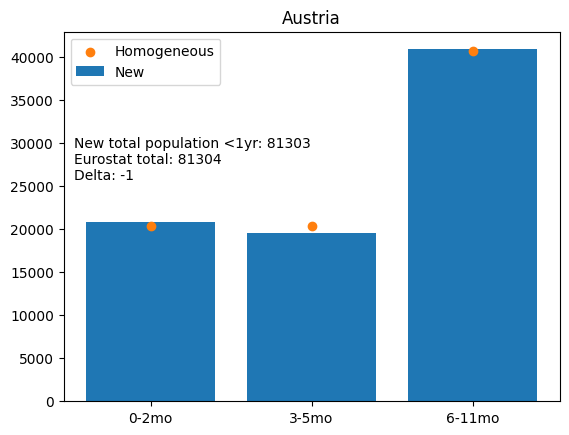

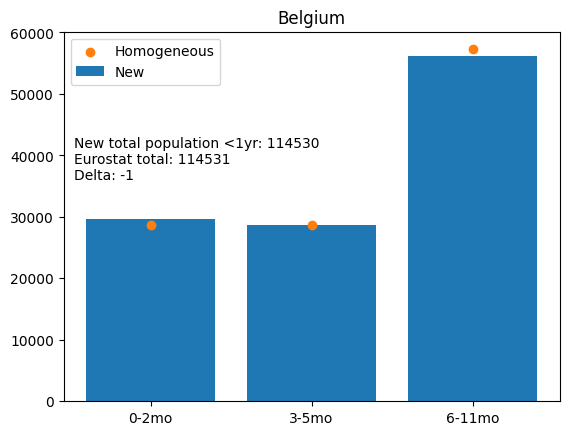

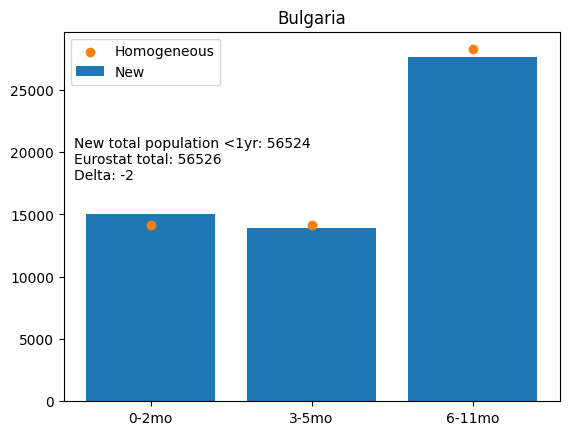

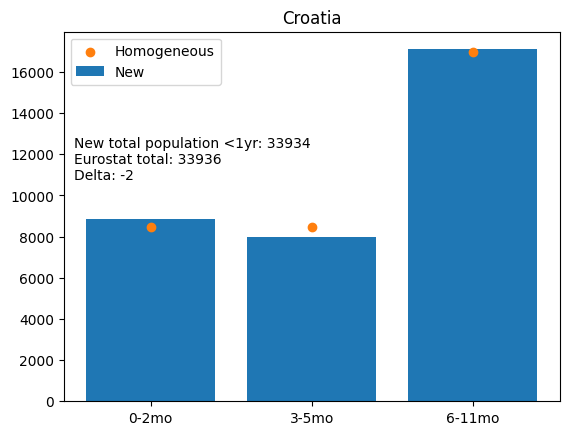

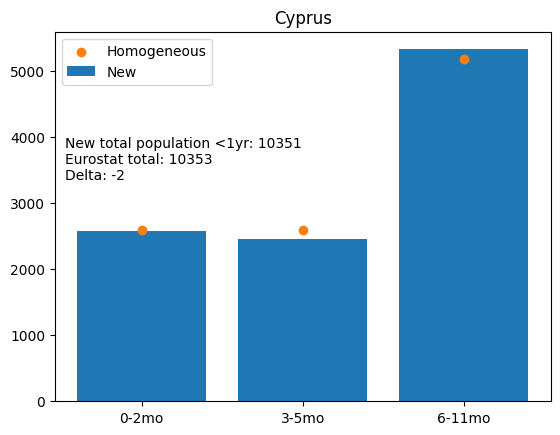

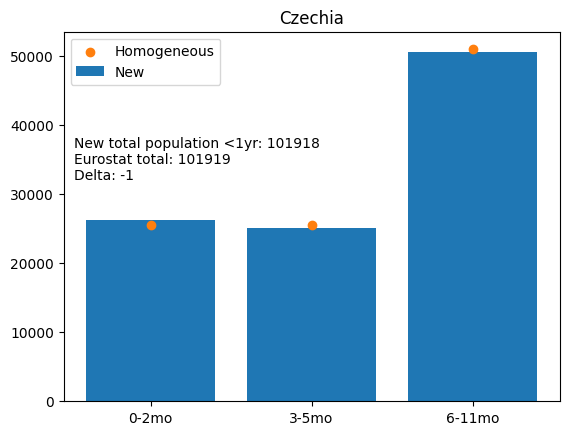

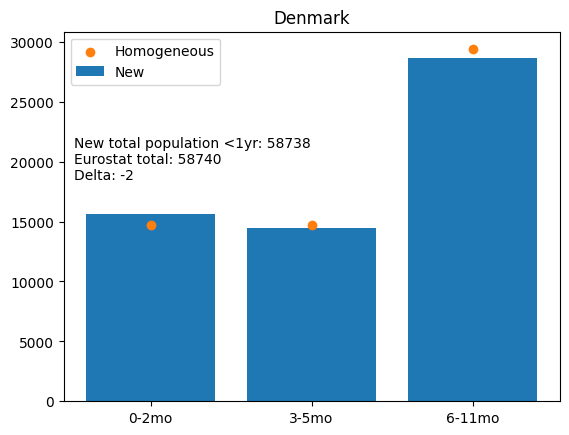

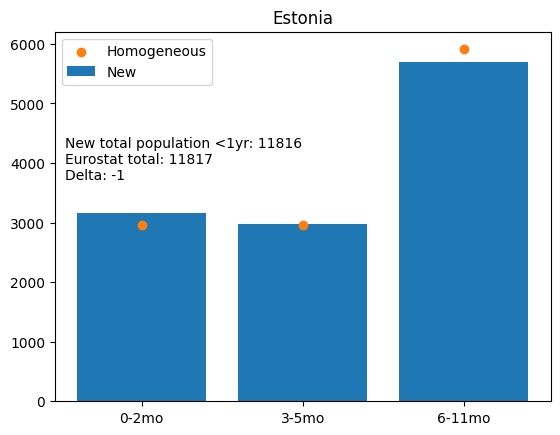

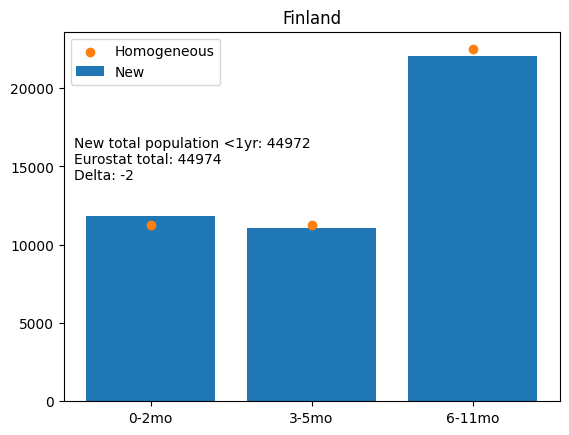

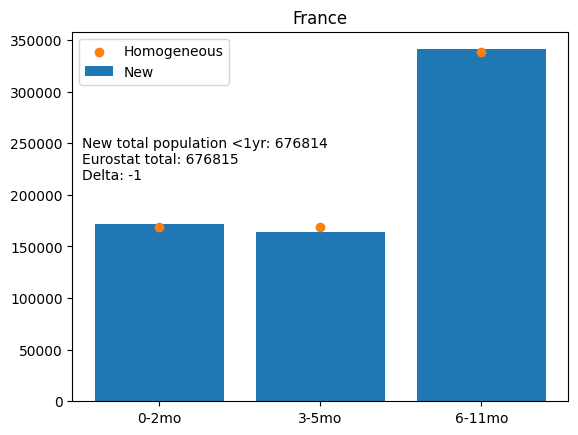

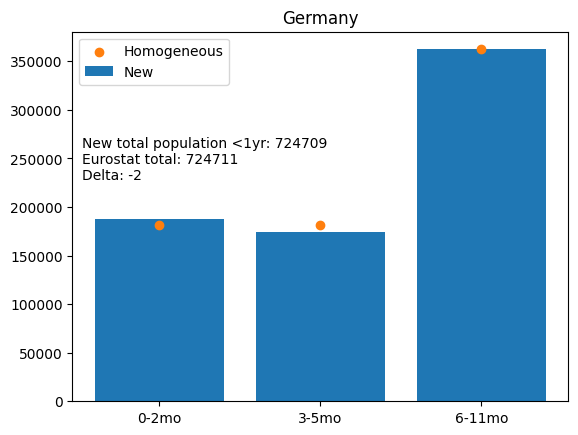

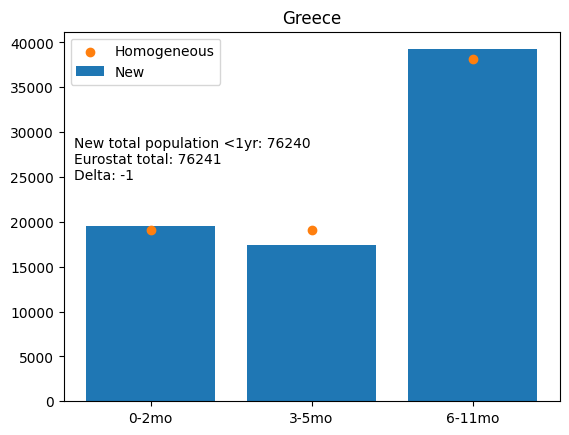

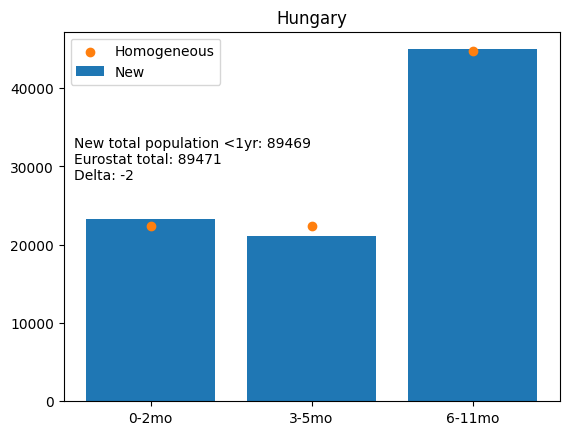

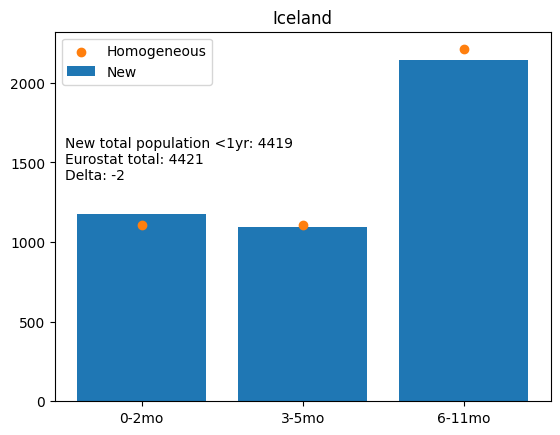

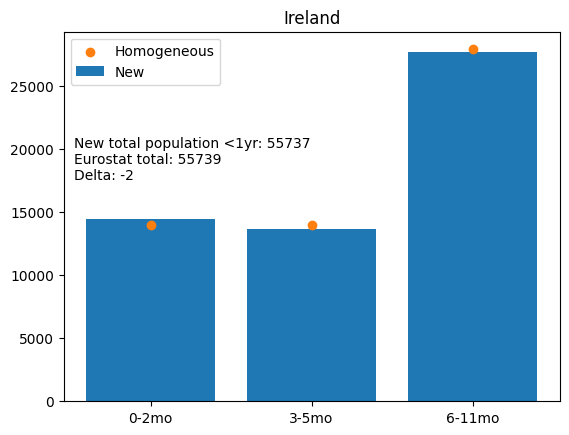

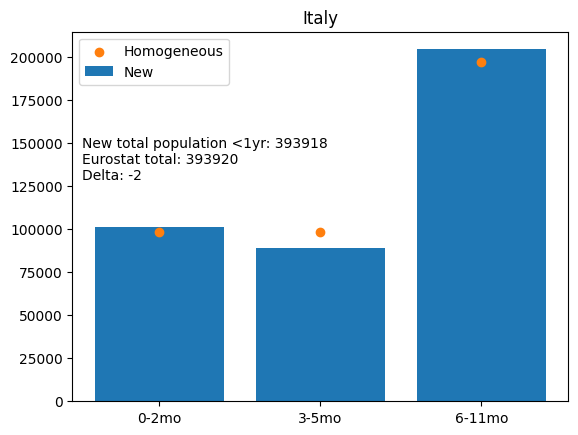

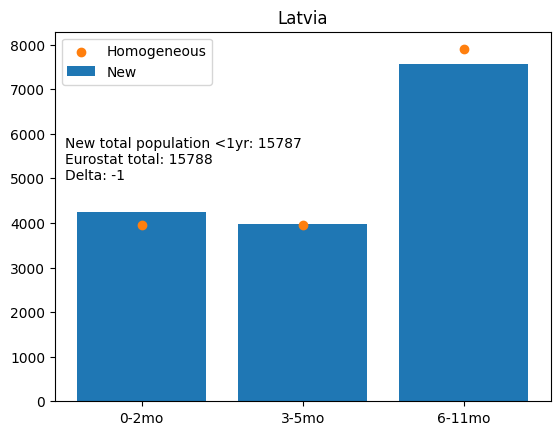

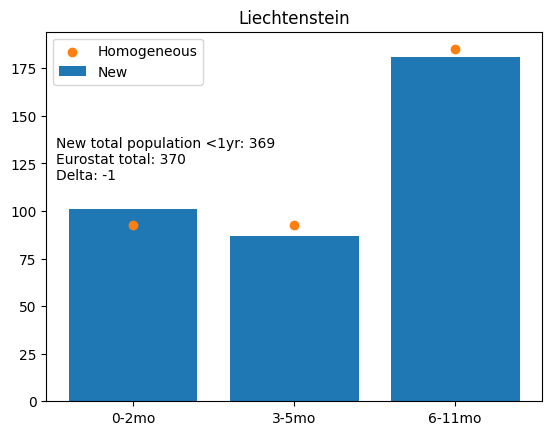

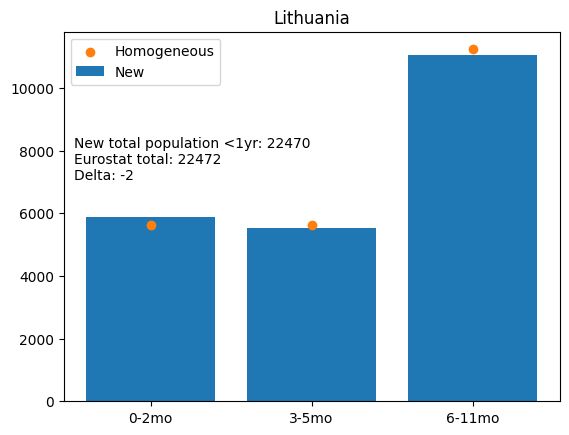

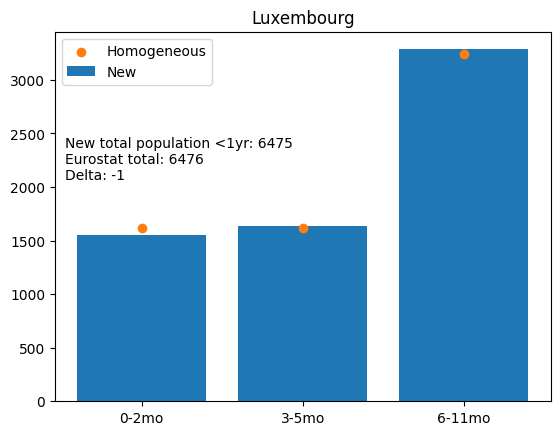

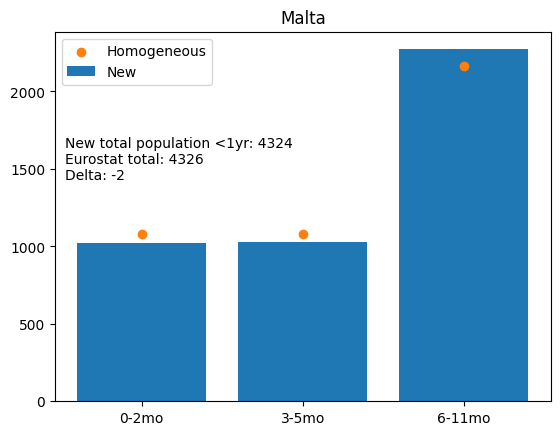

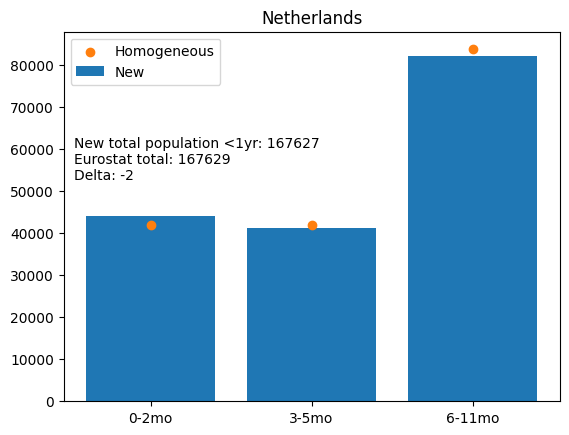

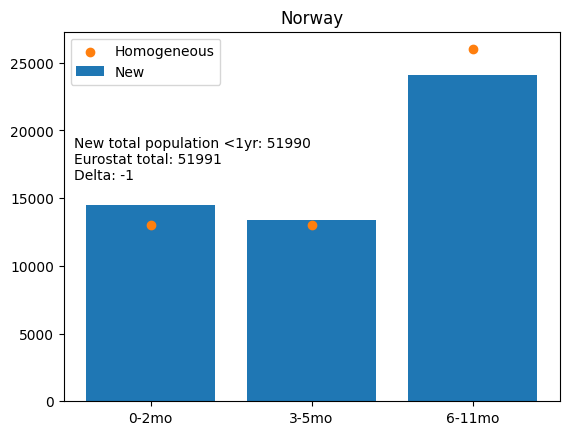

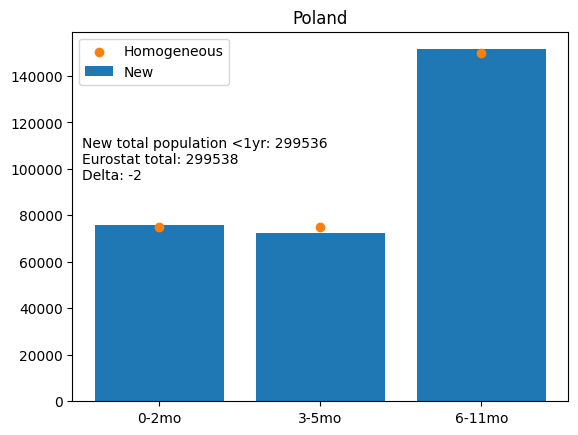

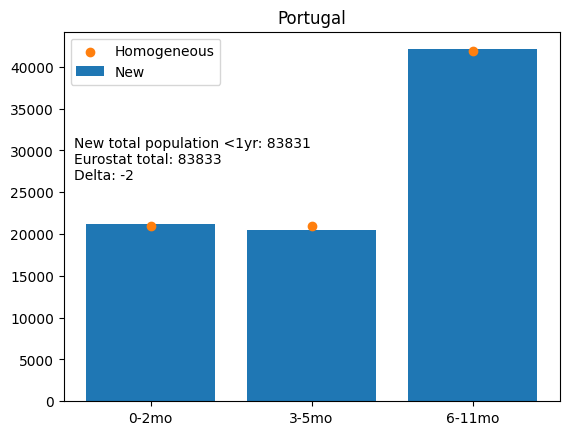

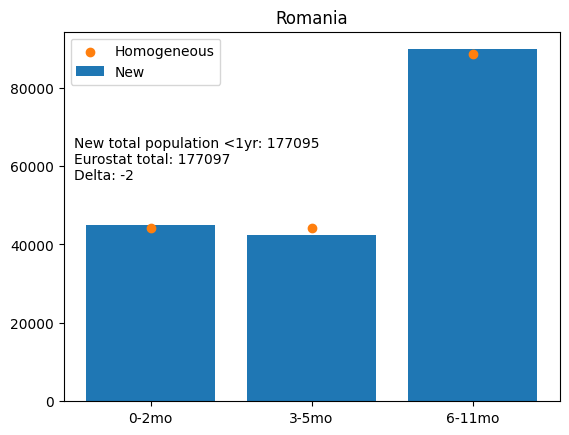

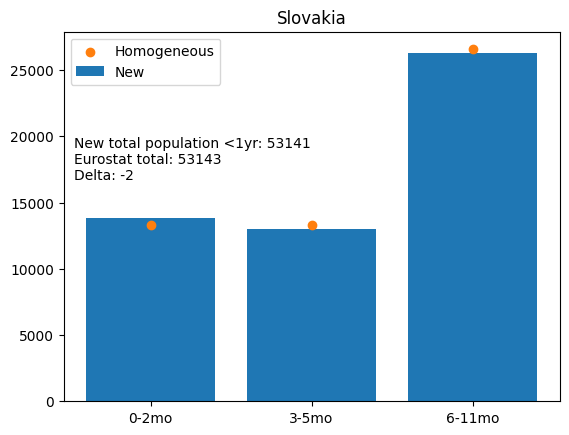

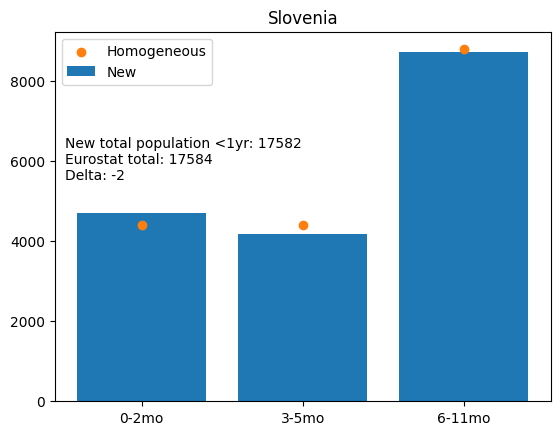

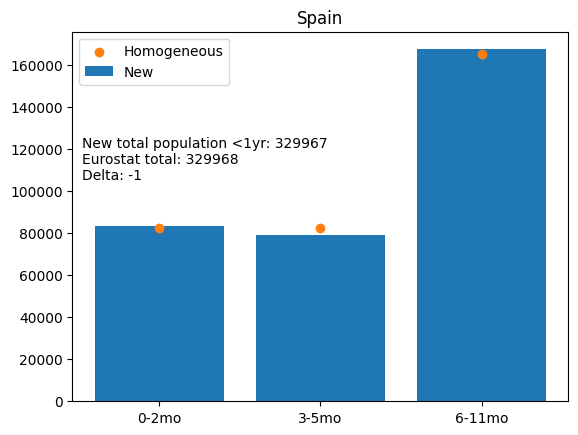

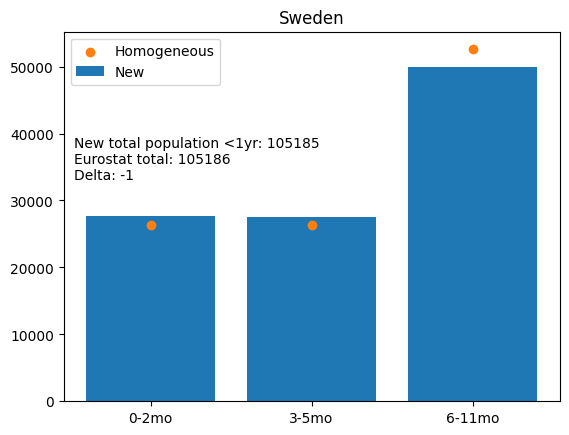

In [6]:
## checks on the share of population in each <1yr sub-group
for country in df_total.country.unique():

    # get results for novel computation
    df_country = df_total[(df_total.country == country)]
    subgroups_1yr = df_country.loc[df_country.age_group.isin(["0-2mo", "3-5mo", "6-11mo"])].population.values
    total_population_1yr = np.sum(subgroups_1yr)

    # check we match eurostat total and compare with homogeneous computation
    total_poulation_1yr_eurostat = population[(population.geo == country) & (population.TIME_PERIOD == 2023) & (population.age == "Less than 1 year")].OBS_VALUE.values[0]
    subgroups_1yr_homogeneous = total_poulation_1yr_eurostat * np.array([1./4., 1./4., 1./2.])

    # delta between new and homogeneous
    delta = total_population_1yr - total_poulation_1yr_eurostat

    # plot
    plt.bar(['0-2mo', '3-5mo', '6-11mo'], subgroups_1yr, label='New')
    plt.scatter(['0-2mo', '3-5mo', '6-11mo'], subgroups_1yr_homogeneous, label='Homogeneous')
    plt.annotate(f"New total population <1yr: {total_population_1yr:.0f}\nEurostat total: {total_poulation_1yr_eurostat:.0f}\nDelta: {delta:.0f}", xy=(0.02, 0.6), xycoords='axes fraction')
    plt.title(country)
    plt.legend(loc="upper left")
    plt.show()

In [7]:
# extended age groups, needed to compute synthetic data 
# these age groups match the ones in the RESCEU data 
age_groups_extended = {'0-2mo': {"groups": ['Less than 1 year']},
              '3-5mo': {"groups": ['Less than 1 year']},
              '6-11mo': {"groups": ['Less than 1 year']},
              '12-35mo': {"groups": ['1 year', '2 years']}, 
              '36-59mo': {"groups": ['3 years', '4 years']},
              '5-17y': {"groups": [f"{i} years" for i in np.arange(5, 18)]},
              '18-64y': {"groups": [f"{i} years" for i in np.arange(18, 65)]},
              '65-74y': {"groups": [f"{i} years" for i in np.arange(65, 75)]},
              '75-84y': {"groups": [f"{i} years" for i in np.arange(75, 85)]},
              '85+y': {"groups": [f"{i} years" for i in np.arange(85, 100)] + ['Open-ended age class']}}

# get population data for each country for extended age groups
df_total_extended = pd.DataFrame() 
for location in countries.country.values:
    births_country = births.loc[births.geo == location]
    df_country = get_population_data(population, location, births_country, age_groups_dict=age_groups_extended, year=2023)
    df_total_extended = pd.concat([df_total_extended, df_country], ignore_index=True)

df_total_extended.head()

,country,age_group,population
0,Austria,0-2mo,20859
1,Austria,3-5mo,19589
2,Austria,6-11mo,40855
3,Austria,12-35mo,173540
4,Austria,36-59mo,176629


In [8]:
# do some checks on total population
for country in df_total_extended.country.unique():
    df_country = df_total_extended[(df_total_extended.country == country)]
    print(f"{country}: {df_country.population.sum()/1e6:.2f} M")

Austria: 9.10 M
Belgium: 11.74 M
Bulgaria: 6.45 M
Croatia: 3.85 M
Cyprus: 0.95 M
Czechia: 10.83 M
Denmark: 5.93 M
Estonia: 1.37 M
Finland: 5.56 M
France: 68.28 M
Germany: 83.12 M
Greece: 10.41 M
Hungary: 9.60 M
Iceland: 0.39 M
Ireland: 5.27 M
Italy: 59.00 M
Latvia: 1.88 M
Liechtenstein: 0.04 M
Lithuania: 2.86 M
Luxembourg: 0.66 M
Malta: 0.54 M
Netherlands: 17.81 M
Norway: 5.49 M
Poland: 36.75 M
Portugal: 10.52 M
Romania: 19.05 M
Slovakia: 5.43 M
Slovenia: 2.12 M
Spain: 48.09 M
Sweden: 10.52 M


In [9]:
# save to csv
df_total_extended.to_csv("./population_estimates_extended.csv", index=False)